# Web scraping med requests och Beautiful Soup

Vi kan använda biblioteken requests och Beautiful Soup för att samla in data från webben.

I den här notebooken kommer jag att samla in resultat från alla internationella stavhoppstävlingar under 2024 från internationella [friidrottsförbundets hemsida](https://worldatheltics.org). 

requests ([dokumentation](https://requests.readthedocs.io/en/latest/)) är ett bibliotek för att göra just *requests*, alltså anrop till en server.

I sin enklaste form räcker det med en webadress som argument till funktionen `get()`. Funktionen `get()` returnerar ett `Response`-objekt.

Beautiful Soup ([dokumentation](https://www.crummy.com/software/BeautifulSoup/bs4/doc/)) är ett bibliotek som låter oss läsa in ostrukturerad data som html- eller xml-filer och filtera och söka på taggar och attribut.

In [23]:
# Import modules

import requests
from bs4 import BeautifulSoup
import pandas as pd
from time import sleep

In [2]:
# This cell fetches all 139 pages of results.

# Create an empty dictionary to fill with data
# data = {}

# There are 139 pages of results - loop through a range and fill the data with the results.
# for p in range(1, 140):
#    data[p] = requests.get(f'https://worldathletics.org/records/toplists/jumps/pole-vault/all/men/senior/2024?regionType=world&page={p}&bestResultsOnly=false&maxResultsByCountry=all&eventId=10229616&ageCategory=senior')
#    sleep(.1)

Vi kör `requests.get()` med URL:en till sidan med stavhoppsresultat och sparar resultatet, alltså `Response`-objektet, i variabeln `response`.

In [24]:
# This cell only fetches the first page of results

response = requests.get(f'https://worldathletics.org/records/toplists/jumps/pole-vault/all/men/senior/2024?regionType=world&page=1&bestResultsOnly=false&maxResultsByCountry=all&eventId=10229616&ageCategory=senior')

`response` har bland annat attributet `content`, som innehåller källkoden för sidan som vi just hämtade.

In [25]:
print(response.content)

b'\n\n<!DOCTYPE html>\n<html lang="en">\n<head>\n    <meta charset="utf-8" />\n    <meta name="viewport" content="width=device-width, initial-scale=1.0">\n\n    <title>\n        Pole Vault - men - senior - all - 2024  \n    </title>\n    <link rel="canonical" href="https://worldathletics.org/records/toplists/jumps/pole-vault/all/men/senior/2024" />\n\n    \n    <meta charset="utf-8" />\n    <meta name="Description" />\n    <meta http-equiv="X-UA-Compatible" content="IE=edge">\n    <meta name="viewport" content="width=device-width, initial-scale=1.0, maximum-scale=1.0, minimum-scale=1, user-scalable=yes">\n\n    \n\n    \n    <link rel="shortcut icon" href="/favicon.ico" />\n    \n    \n\n    \n    <meta name="application-name" content="" />\n    <meta name="msapplication-TileColor" content="#000000" />\n    <meta name="msapplication-square70x70logo" content="/Assets/Images/layout/other-touch/tiny.png" />\n    <meta name="msapplication-square150x150logo" content="/Assets/Images/layout/o

Den källkoden kan vi använda för att skapa ett `BeautifulSoup`-objekt som vi kallar `soup`.

In [26]:
soup = BeautifulSoup(response.content)

In [27]:
soup


<!DOCTYPE html>

<html lang="en">
<head>
<meta charset="utf-8"/>
<meta content="width=device-width, initial-scale=1.0" name="viewport"/>
<title>
        Pole Vault - men - senior - all - 2024  
    </title>
<link href="https://worldathletics.org/records/toplists/jumps/pole-vault/all/men/senior/2024" rel="canonical"/>
<meta charset="utf-8">
<meta name="Description"/>
<meta content="IE=edge" http-equiv="X-UA-Compatible"/>
<meta content="width=device-width, initial-scale=1.0, maximum-scale=1.0, minimum-scale=1, user-scalable=yes" name="viewport"/>
<link href="/favicon.ico" rel="shortcut icon"/>
<meta content="" name="application-name">
<meta content="#000000" name="msapplication-TileColor">
<meta content="/Assets/Images/layout/other-touch/tiny.png" name="msapplication-square70x70logo"/>
<meta content="/Assets/Images/layout/other-touch/square.png" name="msapplication-square150x150logo"/>
<meta content="/Assets/Images/layout/other-touch/wide.png" name="msapplication-wide310x150logo"/>
<met

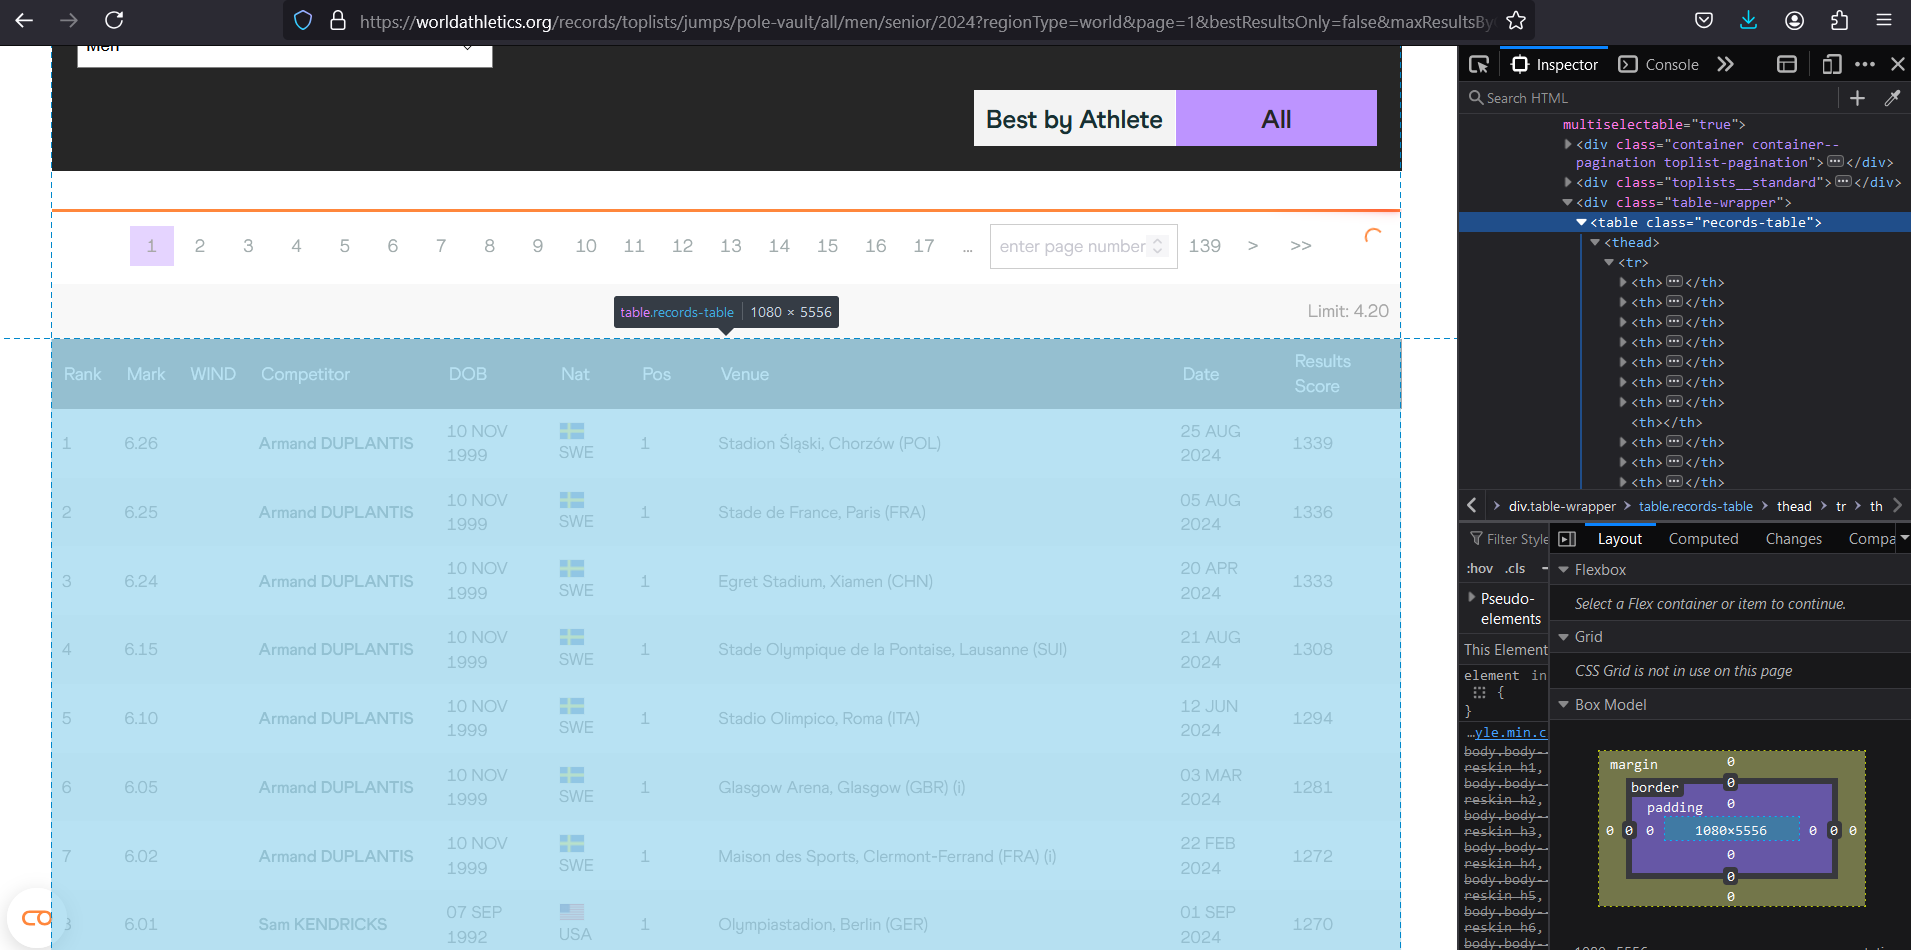

Vi använder webbläsarens *Inspektor*-fönster (`F12`) för att hitta elementet vi söker. I det här fallet en tabell som har klassen `records-table`.

Nu kan vi använda metoden `find()` för att hitta tabellen i vår `soup` och spara den som variabeln `table`.

In [28]:
table = soup.find('table', attrs={'class': 'records-table'})

In [29]:
table

<table class="records-table">
<thead>
<tr>
<th>
                                        Rank
                                    </th>
<th>
                                        Mark
                                    </th>
<th>
                                            WIND
                                        </th>
<th>
                                        Competitor
                                    </th>
<th>
                                        DOB
                                    </th>
<th>
                                        Nat
                                    </th>
<th>
                                        Pos
                                    </th>
<th></th>
<th>
                                        Venue
                                    </th>
<th>
                                        Date
                                    </th>
<th>
                                            Results Score
                                        </th

Vi kan nu skapa en lista med alla rader i tabellen genom `find_all()`-metoden. `tr` är html-taggen som motsvarar en tabellrad.

In [30]:
rows = table.find_all('tr')

Den första raden `rows[0]` innehåller namnen på kolumnerna, uppdelade i `th`-taggar. Vi kan köra `find_all()` igen för att loopa över alla `th`-elementen. Vi använder attributet `text` för att komma åt själva textinnehållet, och metoden `strip()` för att rensa bort *whitespace* som mellanslag och liknande.

In [31]:
columns = [th.text.strip() for th in rows[0].find_all('th')]
columns

['Rank',
 'Mark',
 'WIND',
 'Competitor',
 'DOB',
 'Nat',
 'Pos',
 '',
 'Venue',
 'Date',
 'Results Score']

Nu har vi en lista med kolumn-namnen. Vi skapar en `dict` med namnen som nycklar och tomma listor som värden kopplade till nycklarna.

In [32]:
data_dict = {c: [] for c in columns}
data_dict

{'Rank': [],
 'Mark': [],
 'WIND': [],
 'Competitor': [],
 'DOB': [],
 'Nat': [],
 'Pos': [],
 '': [],
 'Venue': [],
 'Date': [],
 'Results Score': []}

Nu vill vi fylla listorna i `data_dict` med värdena från tabellen som hör till respektive kolumn.

Vi loopar över alla rader utom den första, `rows[1:]`, och använder funktionen `zip()` för att loopa över en kombination av värdena i tabellen och listorna i `data_dict`.

In [33]:
# If we only fetched one page of results, we run this cell

for row in rows[1:]:
    for td, col in zip(row.find_all('td'), data_dict.values()):
        col.append(td.text.strip())

In [16]:
# Only use this cell if multiple pages were fetched

# for page in data.values():
#     soup = BeautifulSoup(page.content)
#     table = soup.find('table', attrs={'class': 'records-table'})
#     rows = table.find_all('tr')
#     for row in rows[1:]:
#         for td, col in zip(row.find_all('td'), data_dict.values()):
#             col.append(td.text.strip())

Nu har vi en `dict` med kolumnnamnen som nycklar, och listor med observationer som värden.

In [45]:
data_dict

{'Rank': ['1',
  '2',
  '3',
  '4',
  '5',
  '6',
  '7',
  '8',
  '9',
  '9',
  '9',
  '9',
  '9',
  '9',
  '9',
  '16',
  '17',
  '17',
  '17',
  '17',
  '21',
  '21',
  '21',
  '24',
  '24',
  '24',
  '24',
  '24',
  '24',
  '24',
  '24',
  '24',
  '33',
  '33',
  '33',
  '33',
  '33',
  '33',
  '33',
  '33',
  '41',
  '41',
  '41',
  '41',
  '41',
  '46',
  '47',
  '47',
  '47',
  '47',
  '47',
  '52',
  '52',
  '54',
  '54',
  '54',
  '54',
  '54',
  '54',
  '54',
  '54',
  '62',
  '62',
  '62',
  '62',
  '62',
  '62',
  '62',
  '62',
  '62',
  '62',
  '62',
  '62',
  '62',
  '62',
  '62',
  '62',
  '62',
  '62',
  '62',
  '62',
  '62',
  '62',
  '62',
  '62',
  '62',
  '62',
  '62',
  '62',
  '62',
  '62',
  '62',
  '62',
  '62',
  '62',
  '62',
  '62',
  '62',
  '62',
  '62'],
 'Mark': ['6.26',
  '6.25',
  '6.24',
  '6.15',
  '6.10',
  '6.05',
  '6.02',
  '6.01',
  '6.00',
  '6.00',
  '6.00',
  '6.00',
  '6.00',
  '6.00',
  '6.00',
  '5.97',
  '5.95',
  '5.95',
  '5.95',
  '5.95'

Data strukturerad på det här sättet funkar utmärkt för att skapa en `DataFrame`.

Här nedan följer en kort EDA som lämnas okommenterad.

In [46]:
df = pd.DataFrame(data_dict)

In [36]:
df.head()

,Rank,Mark,WIND,Competitor,DOB,Nat,Pos,,Venue,Date,Results Score
0,1,6.26,,Armand DUPLANTIS,10 NOV 1999,SWE,1,,"Stadion Śląski, Chorzów (POL)",25 AUG 2024,1339
1,2,6.25,,Armand DUPLANTIS,10 NOV 1999,SWE,1,,"Stade de France, Paris (FRA)",05 AUG 2024,1336
2,3,6.24,,Armand DUPLANTIS,10 NOV 1999,SWE,1,,"Egret Stadium, Xiamen (CHN)",20 APR 2024,1333
3,4,6.15,,Armand DUPLANTIS,10 NOV 1999,SWE,1,,"Stade Olympique de la Pontaise, Lausanne (SUI)",21 AUG 2024,1308
4,5,6.10,,Armand DUPLANTIS,10 NOV 1999,SWE,1,,"Stadio Olimpico, Roma (ITA)",12 JUN 2024,1294


In [19]:
df.describe()

,Rank,Mark,WIND,Competitor,DOB,Nat,Pos,,Venue,Date,Results Score
count,13883,13883,13883,13883,13883,13883,13883,13883,13883,13883,13883
unique,177,177,1,3487,1643,88,264,1,1152,218,177
top,12920,4.20,,Martin PLAKK,,USA,1,,"Hayward Field, Eugene, OR (USA)",13 JAN 2024,780
freq,964,964,13883,27,3404,4148,2146,13883,167,359,964


In [20]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13883 entries, 0 to 13882
Data columns (total 11 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   Rank           13883 non-null  object
 1   Mark           13883 non-null  object
 2   WIND           13883 non-null  object
 3   Competitor     13883 non-null  object
 4   DOB            13883 non-null  object
 5   Nat            13883 non-null  object
 6   Pos            13883 non-null  object
 7                  13883 non-null  object
 8   Venue          13883 non-null  object
 9   Date           13883 non-null  object
 10  Results Score  13883 non-null  object
dtypes: object(11)
memory usage: 1.2+ MB


In [52]:
df = df.astype({'Rank': 'int', 'Mark': 'float', 'DOB': 'datetime64[s]', 'Date': 'datetime64[s]', 'Results Score': 'int'})

In [22]:
df.describe()

,Rank,Mark,DOB,Date,Results Score
count,13883.000000,13883.000000,10479,13883,13883.000000
mean,6767.597781,4.750946,2001-12-28 11:35:44,2024-04-18 07:40:50,927.119427
min,1.000000,4.200000,1972-04-16 00:00:00,2024-01-02 00:00:00,780.000000
25%,3405.000000,4.410000,1999-07-03 00:00:00,2024-02-16 00:00:00,835.000000
50%,6646.000000,4.700000,2002-12-05 00:00:00,2024-04-26 00:00:00,913.000000
75%,10339.000000,5.010000,2005-06-02 00:00:00,2024-06-09 00:00:00,996.000000
max,12920.000000,6.260000,2010-09-12 00:00:00,2024-09-03 00:00:00,1339.000000
std,3924.988487,0.398300,NaN,NaN,107.240083
